# Finding Cu crystal band structure via the Augmented Plane method

This project is adapted from (Thijssen, 2013, p. 135) and uses the potential used in that book.

## Theory

APW is a method for solving the single particle Schrodinger equation in a crystal. It uses the variational principle in the plane wave basis (this is viable due to Bloch's theorem (Griffiths, 2018, p. 239)). A basis element for an eigenstate labelled $\vec{k}$ is (Thijssen, 2013, p. 134):

$$\psi_{\vec{k} + \vec{K}} = e^{i(\vec{k} + \vec{K})\cdot\vec{r}}\tag{1}$$

Due to the size of the potential near the nuclei, the basis set required is too large. APW solves this problem with the Muffin approximation. A basis is used that solves the equation near the nuclei ($r<R$) exactly and is a plane wave in the $r>R$ region (these solutions correspond to an exact solution when $r<R$ and a constant potential when $r>R$, for more details see (Slater, 1937, p. 846)). The two parts of the solution are related via boundary conditions at $R$. This allows for the variational method to be applied efficiently. For a full description of the theory see (Thijssen, 2013, p. 135) or (Haule, 2015) or (Slater, 1937, p. 846). For a more in-depth calculation, see (Burdick, 1962, p.138).

## Implementation

The variational equations are not linear, making the problem much harder to solve. In this implementation, a brute force approach has been followed. For a given $\vec{k}$, a list of energies (mesh) over a certain range is defined; the determinant associated with each of these energies is then found. The energies for $\vec{k}$ then corresponds to the energies where the determinant changes sign.

This notebook applies this method to Cu between $\Gamma = \vec{0}$ and $X = \frac{2\pi}{a}\vec{x}$. The band structure found corresponds to the experimental data (Thijssen, 2013, p. 140). Note that one of the higher energy bands is not found, this is simply due to the mesh used not being fine enough.



In [17]:
import numpy as np
from scipy import special as sp
import matplotlib.pyplot as plt
import itertools

In [18]:
#constants
a = 6.83087
vol = (a**3)/4

#simulation parameters
l_max = 6
cut = 4
N = 10**3

In [19]:
#define recipricol lattice vectors
b1 = 2*np.pi*np.array([-1,1,1])/a
b2 = 2*np.pi*np.array([1,-1,1])/a
b3 = 2*np.pi*np.array([1,1,-1])/a

Ks = [l*b1 + m*b2 + n*b3 for l,m,n in itertools.product(range(-cut,cut+1), repeat=3) 
      if np.linalg.norm(l*b1 + m*b2 + n*b3) < cut]
nKs = len(Ks)

#define muffin tin mesh
rs = np.linspace(0,2.4,num=N)
r_max = rs[-1]
h = rs[1] - rs[0]
h2 = h**2
h12 = h2/12


In [20]:
#deduce some of muffin tin f values 
def V(r):
    term1 = 29.*np.exp(-2.3151241717834*(r**0.81266614122432) + (2.1984250222603E-2)*(r**4.2246376280056))
    term2 = -0.15595606773483*r - (3.1350051440417E-3)*r**2 + (5.1895222293006E-2)*r**3 - (2.8027608685637E-2)*r**4
    return -(term1 + term2)/r

Vs = V(rs)
fls = np.array([l*(l+1)/rs**2 for l in range(l_max)])
fls[:,0] = np.zeros(l_max)


C:\Users\willi\AppData\Local\Temp\ipykernel_3868\3736397557.py:5: RuntimeWarning: divide by zero encountered in divide
  return -(term1 + term2)/r
C:\Users\willi\AppData\Local\Temp\ipykernel_3868\3736397557.py:8: RuntimeWarning: invalid value encountered in divide
  fls = np.array([l*(l+1)/rs**2 for l in range(l_max)])
C:\Users\willi\AppData\Local\Temp\ipykernel_3868\3736397557.py:8: RuntimeWarning: divide by zero encountered in divide
  fls = np.array([l*(l+1)/rs**2 for l in range(l_max)])


In [21]:
#generate A
A = np.empty([nKs,nKs])
for i in range(nKs):
    A[i,i] = 1 - 4*np.pi*(r_max**3)/(3*vol)
    for j in range(i):
        kDiff = np.linalg.norm(Ks[i]-Ks[j])
        A[i,j] = -4*np.pi*(r_max**2)*sp.spherical_jn(1,kDiff*r_max)/(vol*kDiff)
        A[j,i] = A[i,j]

In [22]:
#code for solution to the muffin part
def getRatio(l,E):
    fs = fls[l] + 2*(Vs - E) 
    
    us = np.empty(N)
    us[0] = 0
    us[1] = rs[1]**(l+1)

    fn = fs[1]
    w0 = 0
    w1 = (1 - h12*fn)*us[1]
    
    for n in range(1,N-1):
        w2 = 2*w1 - w0 + h2*us[n]*fn
        fn1 = fs[n+1]
        us[n+1] = w2/(1 - h12*fn1)
        w0 = w1
        w1 = w2
        fn = fn1
 
    dudr  = (us[-1]-us[-2])/h

    return dudr/us[-1] -  1/r_max


In [23]:
def findDet(k,E):
    """
    Finds variational problem determinant.
    """

    #set up k dependent matricies 
    B = np.empty([nKs,nKs])
    C = np.empty([l_max,nKs,nKs])
    qs = [k + K for K in Ks]

    #find B and C
    for i in range(nKs):
        qi = np.linalg.norm(qs[i])
        for j in range(i+1):
            qj = np.linalg.norm(qs[j])
            qDot = qs[i] @ qs[j]
            B[i,j] = A[i,j]*qDot/2
            cosij = qDot/(qi*qj) if qi != 0 and qj != 0 else 1
            for l in range(l_max): 
                C[l,i,j] = (2*l + 1)*2*np.pi*(r_max**2)*sp.eval_legendre(l,cosij)*sp.spherical_jn(l,qi*r_max)*sp.spherical_jn(l,qj*r_max)/vol
                C[l,j,i] = C[l,i,j]
            B[j,i] = B[i,j]
            
    #find H
    H = -E*A + B
    for l in range(l_max):
        H += C[l]*getRatio(l,E)
    
    #find det and return
    return np.linalg.det(H)


In [24]:
def findZero(lst,k):
    """
    Given a list, finds the list elements that change sign and a list the k arrays of the same length.
    """
    
    ks = []
    zeroIndexs = []
    for i in range(1,len(lst)): 
        if lst[i-1]*lst[i] < 0:
            ks.append(k)
            zeroIndexs.append(int(i))
    return ks,zeroIndexs

In [25]:
#finds the energies for a list of k's
ks = [2*np.pi*np.array([i/20,0,0])/a for i in range(1,21)]
EMesh  = np.arange(-0.04,0.3,step=.005)
kLst = []
indexs = []

for i,k in enumerate(ks):
    detList = [findDet(k,E) for E in EMesh]
    tk,tI =  findZero(detList,k)
    kLst += tk
    indexs += tI

Es = list(map(lambda i: EMesh[i], indexs))


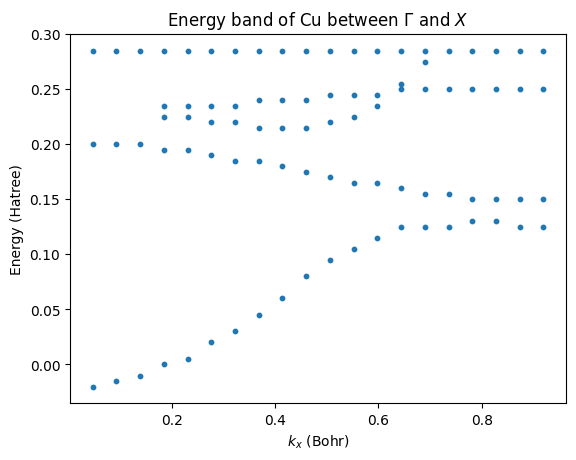

In [26]:
#Graphs 
kx = list(map(lambda k: k[0],kLst))
plt.scatter(kx,Es,s=10)
plt.title(r"Energy band of Cu between $\Gamma$ and $X$")
plt.xlabel(r"$k_x$ (Bohr)")
plt.ylabel("Energy (Hatree)")
plt.show()

## References 

Thijseen J., 2013. Computational Physics. Cambridge: Cambridge University Press

Griffiths D., 2018. Introduction To Quantum Mechanics.  Cambridge: Cambridge University Press

Burdick, G., 1962. Energy Band Structure of Copper. Physical Review, Volume 129, pp. 138-150.

Haule, K., 2015. Application of DFT to crystals. [Online] 
Available at: https://www.physics.rutgers.edu/grad/509/APW.pdf
[Accessed 9 August 2024].

Slater, J., 1937. Wave Functions in a Periodic Potential. Physical Review, Volume 51, pp. 846-851.





